<a href="https://colab.research.google.com/github/anabarrerar/AnaBarrera_Portfolio/blob/main/Diffusion_Model/FineTuning_DM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Requeriments

In [ ]:
!pip install keras-cv==0.4.0 -q
!pip install tensorflow==2.12.0 -q
#!pip install tensorflow==2.9.0 -q
!pip install tqdm -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 595.3/595.3 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 85.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 108.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 41.2 MB/s eta 0:00:00


In [ ]:
from textwrap import wrap
import os
import io
from collections import defaultdict
import keras_cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.experimental.numpy as tnp
from keras_cv.models.stable_diffusion.clip_tokenizer import SimpleTokenizer
from keras_cv.models.stable_diffusion.diffusion_model import DiffusionModel
from keras_cv.models.stable_diffusion.image_encoder import ImageEncoder
from keras_cv.models.stable_diffusion.noise_scheduler import NoiseScheduler
from keras_cv.models.stable_diffusion.text_encoder import TextEncoder
from tensorflow import keras
from tqdm import tqdm
import typing
import matplotlib.image as mpimg

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')

print("GPU:", tf.config.list_physical_devices('GPU'))
print("Num GPUs:", len(physical_devices))

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs: 1


# Data


    "No Finding": 22381,
    "Fracture": 9040,
    "Support Devices": 116011,
    "Atelectasis": 33376,
    "Cardiomegaly": 27000,
    "Consolidation": 14783,
    "Edema": 52246,
    "Enlarged Cardiomediastinum": 10798,
    "Lung Lesion": 9186,
    "Lung Opacity": 10558,
    "Pleural Effusion": 86187,
    "Pleural Other": 3523,
    "Pneumonia": 6039,
    "Pneumothorax": 19448


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

def authenticate_kaggle(key_path):

    # Copy the Kaggle API key from your Drive to the .kaggle directory in your Drive
    !mkdir -p /root/.kaggle
    !cp '{key_path}/kaggle.json' /root/.kaggle/

    # Set the permissions for the Kaggle API key
    !chmod 600 /root/.kaggle/kaggle.json

    # Authenticate with the Kaggle API
    os.environ['KAGGLE_CONFIG_DIR'] = "/root/.kaggle"

    if os.environ.get('KAGGLE_CONFIG_DIR') == "/root/.kaggle":
        print('Authenticated with Kaggle API')

In [ ]:
key_path = "/content/drive/MyDrive/Colab Notebooks"

authenticate_kaggle(key_path)

In [ ]:
!kaggle datasets download -d mimsadiislam/chexpert
!unzip chexpert.zip

In [ ]:
data=pd.read_csv('CheXpert-v1.0-small/train.csv')
data.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


Image shape: (320, 390)
Image data type: uint8
Image color channels: 2
Image pixel values range: 0 255


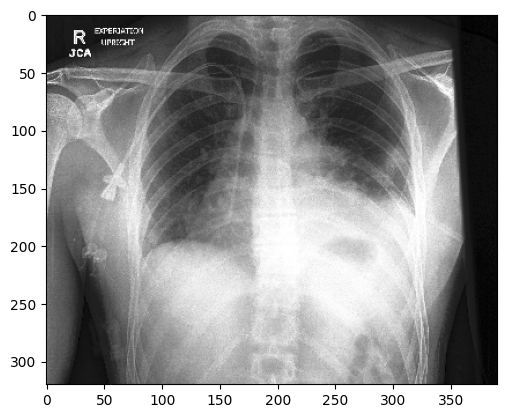

In [ ]:
path = data.loc[9, 'Path']
img = mpimg.imread(path)
plt.imshow(img, cmap='gray')

def print_image_information(image):
  """Prints the principal information of an image.

  Args:
    image: A NumPy array representing the image.
  """

  print("Image shape:", image.shape)
  print("Image data type:", image.dtype)
  print("Image color channels:", image.ndim)
  print("Image pixel values range:", np.min(image), np.max(image))

print_image_information(img)


## Dataset reduction

In [ ]:
data_=data.copy()

In [ ]:
# Define the number of rows you want to keep in your reduced dataset
n_reduced_rows = 50  # desired number of rows (for each patalogy)

# Drop all rows where the "Path" column is null
data_ = data_.dropna(subset=["Path"])

# Get all rows with pathologies (columns that are not "Path","Sex","Age")
pathologies = data_.columns.difference(["Path", "Sex", "Age","Frontal/Lateral","AP/PA"])

# Keep rows with pathologies where the value is equal to 1.0
selected_rows = []
for pathology in pathologies:
    pathology_rows = data_[data_[pathology] == 1.0]
    selected_rows.append(pathology_rows.sample(n=n_reduced_rows))

# Combine the selected rows
data_reduced = pd.concat(selected_rows)

In [ ]:
data_reduced.shape

(700, 19)

In [ ]:
print('Frontal images:',len(data_reduced[data_reduced["Frontal/Lateral"]=='Frontal']))
print('Lateral images:',len(data_reduced[data_reduced["Frontal/Lateral"]=='Lateral']))
print('No Finding:',len(data_reduced[data_reduced["No Finding"]==1.0]))
print('Support Devices:',len(data_reduced[data_reduced["Support Devices"]==1.0]))
print('Fracture:',len(data_reduced[data_reduced["Fracture"]==1.0]))
print('Atelectasis:',len(data_reduced[data_reduced["Atelectasis"]==1.0]))
print('Cardiomegaly:',len(data_reduced[data_reduced["Cardiomegaly"]==1.0]))
print('Consolidation:',len(data_reduced[data_reduced["Consolidation"]==1.0]))
print('Edema:',len(data_reduced[data_reduced["Edema"]==1.0]))
print('Enlarged Cardiomediastinum:',len(data_reduced[data_reduced["Enlarged Cardiomediastinum"]==1.0]))
print('Lung Lesion:',len(data_reduced[data_reduced["Lung Lesion"]==1.0]))
print('Lung Opacity:',len(data_reduced[data_reduced["Lung Opacity"]==1.0]))
print('Pleural Effusion:',len(data_reduced[data_reduced["Pleural Effusion"]==1.0]))
print('Pleural Other:',len(data_reduced[data_reduced["Pleural Other"]==1.0]))
print('Pneumonia:',len(data_reduced[data_reduced["Pneumonia"]==1.0]))
print('Pneumothorax:',len(data_reduced[data_reduced["Pneumothorax"]==1.0]))

Frontal images: 590
Lateral images: 110
No Finding: 53
Support Devices: 349
Fracture: 76
Atelectasis: 138
Cardiomegaly: 114
Consolidation: 85
Edema: 177
Enlarged Cardiomediastinum: 74
Lung Lesion: 65
Lung Opacity: 338
Pleural Effusion: 290
Pleural Other: 61
Pneumonia: 63
Pneumothorax: 95


In [ ]:
data_reduced = data_reduced.reset_index(drop=True)

## Image-caption dataframe

In [ ]:
image_descriptions = []
#description_df = pd.DataFrame(columns=["Path", "Description"])

mapping = {
    "No Finding": ["no abnormalities"]
}

#for index, row in data_.iterrows():
for index, row in tqdm(data_reduced.iterrows(), total=len(data_reduced), desc="Processing Rows"):
    if row["Frontal/Lateral"] == "Frontal": # AP/PA POSITION
        position = row["AP/PA"]
    else:
        position = ""

    if row["No Finding"] == 1.0:      # PATHOLOGIES
      findings = ", no confirmed pathologies"
    else:
      findings = ""

    if row["Support Devices"]==1.0:   #SUPPORT MEDICAL DEVICECS
      devices = ", with support devices"
    elif row["Support Devices"] == 0.0:
      devices = ", support devices unclear"
    elif row["Support Devices"] == -1.0:
      devices= ", without support devices"
    else:
      devices=""

    if row["Enlarged Cardiomediastinum"] == 1.0:   #ENLARGED MEDIASTINUM
      enlarged=", enlarged mediastinum present"
    elif row["Enlarged Cardiomediastinum"] == 0.0:
      enlarged=", enlarged mediastinum unclear"
    elif row["Enlarged Cardiomediastinum"] == -1.0:
      enlarged=", without mediastinum unclear"
    else:
      enlarged=""

    if row["Cardiomegaly"] == 1.0:   #CARDIOMEGALY
      cardiomegaly=", cardiomegaly present"
    elif row["Cardiomegaly"] == 0.0:
      cardiomegaly=", cardiomegaly unclear"
    elif row["Cardiomegaly"] == -1.0:
      cardiomegaly=", without cardiomegaly"
    else:
      cardiomegaly=""


    if row["Lung Opacity"] == 1.0:   # LUNG OPACITY
      lung_op=", lung opacity present"
    elif row["Lung Opacity"] == 0.0:
      lung_op=", lung opacity unclear"
    elif row["Lung Opacity"] == -1.0:
      lung_op=", without lung opacity"
    else:
      lung_op=""

    if row["Lung Lesion"] == 1.0:   # LUNG LESION
      lung_le=", lung lesion present"
    elif row["Lung Lesion"] == 0.0:
      lung_le=", lung lesion unclear"
    elif row["Lung Lesion"] == -1.0:
      lung_le=", without lesion opacity"
    else:
      lung_le=""

    if row["Edema"] == 1.0:   # EDEMA
      edema=", edema present"
    elif row["Edema"] == 0.0:
      edema=", edema unclear"
    elif row["Edema"] == -1.0:
      edema=", without edema"
    else:
      edema=""

    if row["Consolidation"] == 1.0:   # CONSOLIDATION
      consolidation=", consolidation present"
    elif row["Consolidation"] == 0.0:
      consolidation=", consolidation unclear"
    elif row["Consolidation"] == -1.0:
      consolidation=", without consolidation"
    else:
      consolidation=""

    if row["Pneumonia"] == 1.0:   # PNEUMONIA
      pneumonia=", pneumonia present"
    elif row["Pneumonia"] == 0.0:
      pneumonia=", pneumonia unclear"
    elif row["Pneumonia"] == -1.0:
      pneumonia=", without pneumonia"
    else:
      pneumonia=""

    if row["Atelectasis"] == 1.0:   # ATELECTASIS
      atelectasis=", atelectasis present"
    elif row["Atelectasis"] == 0.0:
      atelectasis=", atelectasis unclear"
    elif row["Atelectasis"] == -1.0:
      atelectasis=", without atelectasis"
    else:
      atelectasis=""

    if row["Pneumothorax"] == 1.0:   # PNEUMOTHORAX
      pneumothorax=", pneumothorax present"
    elif row["Pneumothorax"] == 0.0:
      pneumothorax=", pneumothorax unclear"
    elif row["Pneumothorax"] == -1.0:
      pneumothorax=", without pneumothorax"
    else:
      pneumothorax=""

    if row["Pleural Effusion"] == 1.0:   # PLEURAL EFFUSION
      pleural_ef=", pleural effusion present"
    elif row["Pleural Effusion"] == 0.0:
      pleural_ef=", pleural effusion unclear"
    elif row["Pleural Effusion"] == -1.0:
      pleural_ef=", without pleural effusion"
    else:
      pleural_ef=""

    if row["Pleural Other"] == 1.0:   # PLEURAL OTHER
      pleural_ot=", pleural other present"
    elif row["Pleural Effusion"] == 0.0:
      pleural_ot=", pleural other unclear"
    elif row["Pleural Effusion"] == -1.0:
      pleural_ot=", without pleural other"
    else:
      pleural_ot=""

    if row["Fracture"] == 1.0:   # PLEURAL OTHER
      fracture=", fracture present"
    elif row["Fracture"] == 0.0:
      fracture=", fracture unclear"
    elif row["Fracture"] == -1.0:
      fracture=", without fracture"
    else:
      fracture=""


    template = "{} {} chest X-ray, {}, {} years old{}{}{}{}{}{}{}{}{}{}{}{}{}{}"

    no_finding = str(row["No Finding"])  # Convert to string
    image_description = template.format(
        row["Frontal/Lateral"], position, row["Sex"], row["Age"], findings, enlarged, cardiomegaly , lung_op , lung_le, edema , consolidation , pneumonia , atelectasis, pneumothorax , pleural_ef , pleural_ot , fracture, devices
    )

    #description_df = description_df.append({"Path": row["Path"], "Description": image_description}, ignore_index=True)
    #description_df.to_csv("imagen_description_data.csv")

    image_descriptions.append(image_description)

Processing Rows: 100%|██████████| 700/700 [00:00<00:00, 6386.47it/s]


In [ ]:
data_frame = pd.DataFrame({
    "image_path": data_reduced["Path"].tolist(),
    "caption": image_descriptions})

In [ ]:
data_frame

,image_path,caption
0,CheXpert-v1.0-small/train/patient04989/study2/...,"Frontal AP chest X-ray, Female, 79 years old, ..."
1,CheXpert-v1.0-small/train/patient33330/study1/...,"Frontal PA chest X-ray, Male, 73 years old, ca..."
2,CheXpert-v1.0-small/train/patient41351/study9/...,"Frontal AP chest X-ray, Male, 73 years old, ed..."
3,CheXpert-v1.0-small/train/patient01489/study22...,"Frontal AP chest X-ray, Female, 32 years old, ..."
4,CheXpert-v1.0-small/train/patient39979/study2/...,"Frontal AP chest X-ray, Female, 75 years old, ..."
...,...,...
695,CheXpert-v1.0-small/train/patient08251/study4/...,"Frontal AP chest X-ray, Female, 43 years old, ..."
696,CheXpert-v1.0-small/train/patient14590/study5/...,"Frontal AP chest X-ray, Male, 88 years old, lu..."
697,CheXpert-v1.0-small/train/patient39880/study2/...,"Frontal AP chest X-ray, Male, 90 years old, lu..."
698,CheXpert-v1.0-small/train/patient44607/study2/...,"Frontal AP chest X-ray, Female, 54 years old, ..."


```
# Define type hints
ImageDescriptions = typing.List[str]
Pathology = typing.Dict[str, typing.List[str]]

# Load the data
data: Pathology = ...

# Create a list to store the image descriptions
image_descriptions: ImageDescriptions = []

# Iterate over the data and generate an image description for each record
for index, row in tqdm(enumerate(data), total=len(data), desc="Processing Rows"):
    # Get the patient's age
    age: int = row["Age"]

    # Get the patient's chest X-ray position
    position: str = row["Frontal/Lateral"]

    # Get the patient's findings
    findings: str = ""
    if row["No Finding"] == 1.0:
        findings = "no abnormalities"
    else:
        for pathology_key, pathology_values in row.items():
            if pathology_key != "Age" and pathology_key != "Frontal/Lateral" and pathology_key != "No Finding":
                findings += ", {} {}".format(pathology_key, ", ".join(pathology_values))

    # Generate the image description
    image_description: str = "Patient's {} chest X-ray, {} years old, {}".format(position, age, findings)

    # Add the image description to the list
    image_descriptions.append(image_description)

# Save the image descriptions to a file
with open("image_descriptions.csv", "w") as f:
    f.write("\n".join(image_descriptions))
```



In [ ]:
# Image-caption dataframe of the complete dataset
#data_frame = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Diffusers/imagen_description_data.csv')
#data_frame.columns = ['image_path', 'caption']

# Preprocesamiento

Procesamiento del texto de las descripcion de imagenes, utilizando un tokenizador y la creación de secuencias de tokens para una serie de descripciones de datos almacenadas en un DataFrame.

In [ ]:
data_frame.shape

(700, 2)

In [ ]:
# The padding token and maximum prompt length are specific to the text encoder.
# If you're using a different text encoder be sure to change them accordingly.
PADDING_TOKEN = 49407
MAX_PROMPT_LENGTH = 77

# Load the tokenizer.
tokenizer = SimpleTokenizer()

#  Method to tokenize and pad the tokens.
def process_text(caption):
    tokens = tokenizer.encode(caption)
    tokens = tokens + [PADDING_TOKEN] * (MAX_PROMPT_LENGTH - len(tokens))
    return np.array(tokens)


# Collate the tokenized captions into an array.
tokenized_texts = np.empty((len(data_frame), MAX_PROMPT_LENGTH))

all_captions = list(data_frame["caption"].values)
for i, caption in enumerate(all_captions):
    tokenized_texts[i] = process_text(caption)

Creamos un conjunto de datos para entrenar el modelo de difusión a partir de la lista de rutas a imagenes y la lista de textos tokenizados.

In [ ]:
RESOLUTION = 256
AUTO = tf.data.AUTOTUNE
POS_IDS = tf.convert_to_tensor([list(range(MAX_PROMPT_LENGTH))], dtype=tf.int32)

augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.CenterCrop(RESOLUTION, RESOLUTION),
        keras_cv.layers.RandomFlip(),
        tf.keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1),
    ]
)
text_encoder = TextEncoder(MAX_PROMPT_LENGTH)


def process_image(image_path, tokenized_text):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, 2) #originally 3
    image = tf.image.resize(image, (RESOLUTION, RESOLUTION))
    return image, tokenized_text


def apply_augmentation(image_batch, token_batch):
    return augmenter(image_batch), token_batch


def run_text_encoder(image_batch, token_batch):
    return (
        image_batch,
        token_batch,
        text_encoder([token_batch, POS_IDS], training=False),
    )


def prepare_dict(image_batch, token_batch, encoded_text_batch):
    return {
        "images": image_batch,
        "tokens": token_batch,
        "encoded_text": encoded_text_batch,
    }


def prepare_dataset(image_paths, tokenized_texts, batch_size=1):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, tokenized_texts))
    dataset = dataset.shuffle(batch_size * 10)
    dataset = dataset.map(process_image, num_parallel_calls=AUTO).batch(batch_size)
    dataset = dataset.map(apply_augmentation, num_parallel_calls=AUTO)
    dataset = dataset.map(run_text_encoder, num_parallel_calls=AUTO)
    dataset = dataset.map(prepare_dict, num_parallel_calls=AUTO)
    return dataset.prefetch(AUTO)

In [ ]:
# Prepare the dataset.
training_dataset = prepare_dataset(
    np.array(data_frame["image_path"]), tokenized_texts, batch_size=4)

# Take a sample batch and investigate.
sample_batch = next(iter(training_dataset))

for k in sample_batch:
    print(k, sample_batch[k].shape)

images (4, 256, 256, 3)
tokens (4, 77)
encoded_text (4, 77, 768)


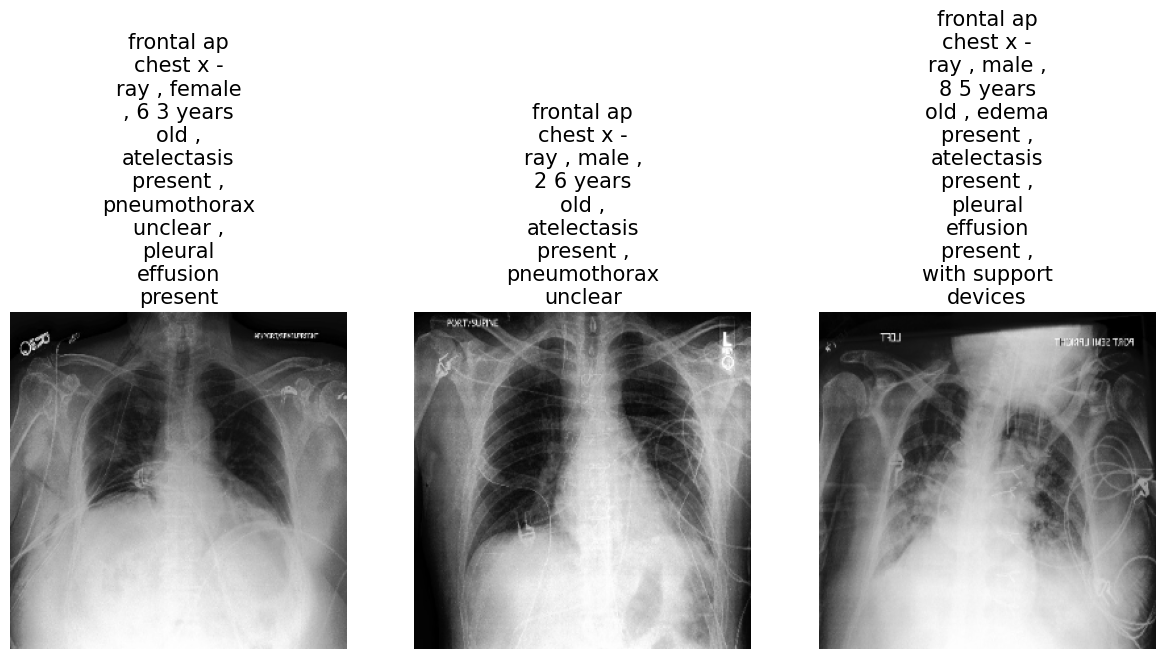

In [ ]:
plt.figure(figsize=(20, 10))

for i in range(3):
    ax = plt.subplot(1, 4, i + 1)
    plt.imshow((sample_batch["images"][i] + 1) / 2)

    text = tokenizer.decode(sample_batch["tokens"][i].numpy().squeeze())
    text = text.replace("<|startoftext|>", "")
    text = text.replace("<|endoftext|>", "")
    text = "\n".join(wrap(text, 12))
    plt.title(text, fontsize=15)

    plt.axis("off")

#Training

In [ ]:
class Trainer(tf.keras.Model):
    # Reference:
    # https://github.com/huggingface/diffusers/blob/main/examples/text_to_image/train_text_to_image.py

    def __init__(
        self,
        diffusion_model,
        vae,
        noise_scheduler,
        use_mixed_precision=False,
        max_grad_norm=1.0,
        **kwargs
    ):
        super().__init__(**kwargs)

        self.diffusion_model = diffusion_model
        self.vae = vae
        self.noise_scheduler = noise_scheduler
        self.max_grad_norm = max_grad_norm

        self.use_mixed_precision = use_mixed_precision
        self.vae.trainable = False

    def train_step(self, inputs):
        images = inputs["images"]
        encoded_text = inputs["encoded_text"]
        batch_size = tf.shape(images)[0]

        with tf.GradientTape() as tape:
            # Project image into the latent space and sample from it.
            latents = self.sample_from_encoder_outputs(self.vae(images, training=False))
            # Know more about the magic number here:
            # https://keras.io/examples/generative/fine_tune_via_textual_inversion/
            latents = latents * 0.18215

            # Sample noise that we'll add to the latents.
            noise = tf.random.normal(tf.shape(latents))

            # Sample a random timestep for each image.
            timesteps = tnp.random.randint(
                0, self.noise_scheduler.train_timesteps, (batch_size,)
            )

            # Add noise to the latents according to the noise magnitude at each timestep
            # (this is the forward diffusion process).
            noisy_latents = self.noise_scheduler.add_noise(
                tf.cast(latents, noise.dtype), noise, timesteps
            )

            # Get the target for loss depending on the prediction type
            # just the sampled noise for now.
            target = noise  # noise_schedule.predict_epsilon == True

            # Predict the noise residual and compute loss.
            timestep_embedding = tf.map_fn(
                lambda t: self.get_timestep_embedding(t), timesteps, dtype=tf.float32
            )
            timestep_embedding = tf.squeeze(timestep_embedding, 1)
            model_pred = self.diffusion_model(
                [noisy_latents, timestep_embedding, encoded_text], training=True
            )
            loss = self.compiled_loss(target, model_pred)
            if self.use_mixed_precision:
                loss = self.optimizer.get_scaled_loss(loss)

        # Update parameters of the diffusion model.
        trainable_vars = self.diffusion_model.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        if self.use_mixed_precision:
            gradients = self.optimizer.get_unscaled_gradients(gradients)
        gradients = [tf.clip_by_norm(g, self.max_grad_norm) for g in gradients]
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        return {m.name: m.result() for m in self.metrics}

    def get_timestep_embedding(self, timestep, dim=320, max_period=10000):
        half = dim // 2
        log_max_period = tf.math.log(tf.cast(max_period, tf.float32))
        freqs = tf.math.exp(
            -log_max_period * tf.range(0, half, dtype=tf.float32) / half
        )
        args = tf.convert_to_tensor([timestep], dtype=tf.float32) * freqs
        embedding = tf.concat([tf.math.cos(args), tf.math.sin(args)], 0)
        embedding = tf.reshape(embedding, [1, -1])
        return embedding

    def sample_from_encoder_outputs(self, outputs):
        mean, logvar = tf.split(outputs, 2, axis=-1)
        logvar = tf.clip_by_value(logvar, -30.0, 20.0)
        std = tf.exp(0.5 * logvar)
        sample = tf.random.normal(tf.shape(mean), dtype=mean.dtype)
        return mean + std * sample

    def save_weights(self, filepath, overwrite=True, save_format=None, options=None):
        # Overriding this method will allow us to use the `ModelCheckpoint`
        # callback directly with this trainer class. In this case, it will
        # only checkpoint the `diffusion_model` since that's what we're training
        # during fine-tuning.
        self.diffusion_model.save_weights(
            filepath=filepath,
            overwrite=overwrite,
            save_format=save_format,
            options=options,
        )

In [ ]:
tf.debugging.set_log_device_placement(True)

#Enable mixed-precision training if the underlying GPU has tensor cores.
USE_MP = True
if USE_MP:
    keras.mixed_precision.set_global_policy("mixed_float16")

image_encoder = ImageEncoder(RESOLUTION, RESOLUTION)
diffusion_ft_trainer = Trainer(
    diffusion_model=DiffusionModel(RESOLUTION, RESOLUTION, MAX_PROMPT_LENGTH),
    # Remove the top layer from the encoder, which cuts off the variance and only
    # returns the mean.
    vae=tf.keras.Model(
        image_encoder.input,
        image_encoder.layers[-2].output,
    ),
    noise_scheduler=NoiseScheduler(),
    use_mixed_precision=USE_MP,
)

# These hyperparameters come from this tutorial by Hugging Face:
# https://huggingface.co/docs/diffusers/training/text2image
lr = 1e-3 #1e-5
beta_1, beta_2 = 0.9, 0.999
weight_decay = (1e-2,)
epsilon = 1e-08

optimizer = tf.keras.optimizers.experimental.AdamW(
    learning_rate=lr,
    weight_decay=weight_decay,
    beta_1=beta_1,
    beta_2=beta_2,
    epsilon=epsilon,
)
# When using Colab it is important to configure the GPU usage when running the model (in the tensorflow case)  ,device='/device:GPU:0'
diffusion_ft_trainer.compile(optimizer=optimizer, loss="mse")

# Fine-tuning

In [ ]:
tf.debugging.set_log_device_placement(True)

epochs = 1
ckpt_path = "finetuned_stable_diffusion.h5"
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    ckpt_path,
    save_weights_only=True,
    monitor="loss",
    mode="min",
)
diffusion_ft_trainer.fit(training_dataset, epochs=epochs, callbacks=[ckpt_callback])

# Inference

In [ ]:
weights_path = tf.keras.utils.get_file(
    origin="https://huggingface.co/sayakpaul/kerascv_sd_pokemon_finetuned/resolve/main/ckpt_epochs_72_res_512_mp_True.h5"
)

img_height = img_width = 320
chest_xrays_model = keras_cv.models.StableDiffusion(
    img_width=img_width, img_height=img_height
)
# We just reload the weights of the fine-tuned diffusion model.}
chest_xrays_model.diffusion_model.load_weights(weights_path)

In [ ]:
prompts = ["Female, 64 years old, with support devices and Lung Lesion and opacity", "Lateral chest x-ray, male, 15 years old", "A pokemon with red eyes"]
images_to_generate = 3
outputs = {}

for prompt in prompts:
    generated_images = chest_xrays_model.text_to_image(
        prompt, batch_size=images_to_generate, unconditional_guidance_scale=40
    )
    outputs.update({prompt: generated_images})